In [1]:
import os
import torch
import torchvision
import tarfile
from torch import nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor']='#ffffff'

In [2]:
from torchvision.datasets.utils import download_url


# Download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: .\cifar10.tgz
['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Transform the Images by applying some operations

In [3]:
# Data Transforms (Normalization & Data Augmentation)
stats = ((0.4914,0.4822,0.4465), # Mean for each channel
         (0.2023,0.1994,0.2010)) # Standard deviation for each channel
train_tfms = transforms.Compose([transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
                                transforms.RandomHorizontalFlip(),
                                #transforms.RandomRotation(),
                                #transforms.RandomResizedCrop(256, scale=(0.5,0.9), ratio= (1,1)),
                                #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(*stats)])

In [4]:
# pytorch Datasets
train_ds = ImageFolder(data_dir+'/train',train_tfms)
valid_ds = ImageFolder(data_dir+'/test',valid_tfms)

In [5]:
batch_size=256

In [6]:
# pytoch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break

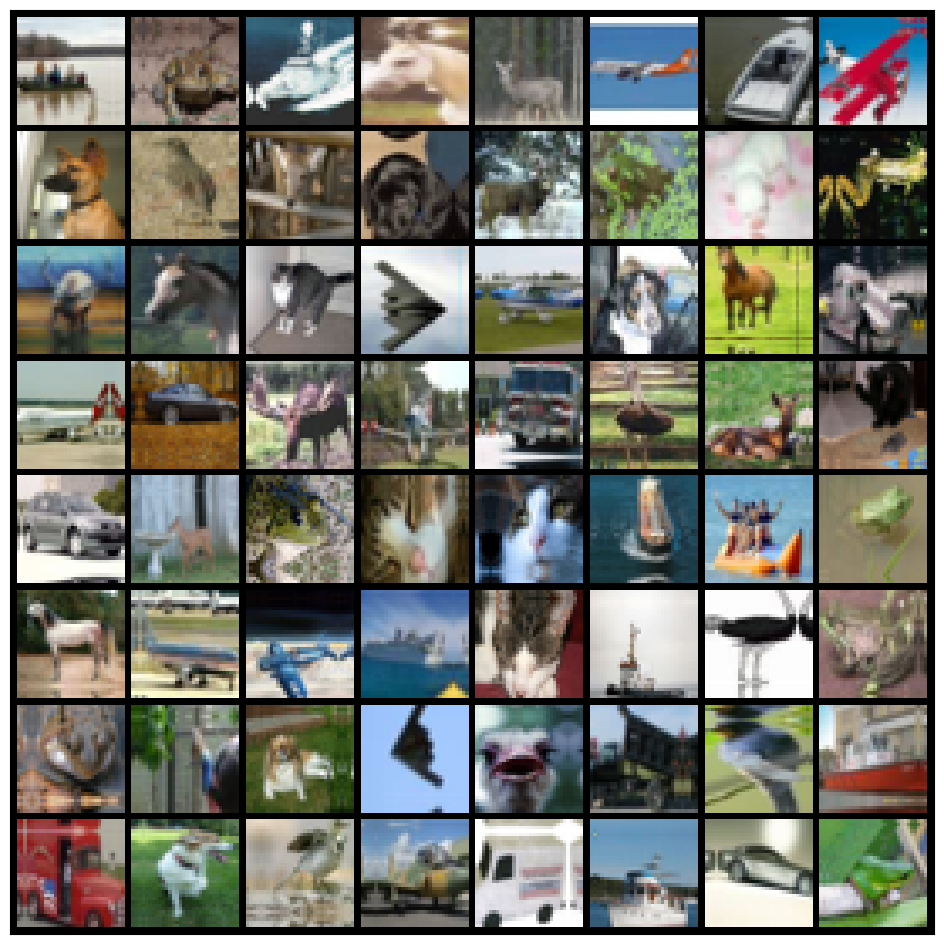

In [8]:
show_batch(train_dl)

In [9]:
torch.cuda.is_available()

True

### Using GPU

In [10]:
def get_default_device():
    """ Pick GPU if available else cpu"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
def to_device(data,device):
    """ Move tensor to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking= True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        """Yield a batch data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)        

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

#### Very Simple Residual Block

In [13]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3,stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding =1)
        self.relu2 = nn.ReLU()

    def forward(self,x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out)+x   # ReLU can be applied before or after adding the input

In [14]:
simple_resnet = to_device(SimpleResidualBlock(), device)
for images,labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

torch.Size([256, 3, 32, 32])


In [15]:
del simple_resnet, images, labels
torch.cuda.empty_cache()

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
def conv_block(in_channels,out_channels,pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        # 256 x 32 x32
        self.conv1=conv_block(in_channels, 64) # 64 x 32 x 32
        self.conv2=conv_block(64, 128, pool=True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128,128), 
                                  conv_block(128,128)) # 128 x 16 x 16

        self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512,512),
                                  conv_block(512,512)) # 512 x 4 x 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                        nn.Flatten(),   # 512
                                        nn.Dropout(0.2), # Make 20% of parameters to zero
                                        nn.Linear(512,num_classes)) # 10

    def forward(self,xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out    

In [18]:
model = to_device(ResNet9(3,10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Training the model

In [35]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Scheduling learning rate to change learning rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training phase
        model.train(True)
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            # Record & Update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs']=lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.300062894821167, 'val_acc': 0.12912455201148987}]

In [21]:
epochs=8
max_lr=0.01
grad_clip = 0.1
weight_decay=1e-4
opt_func = torch.optim.Adam

In [22]:
%%time
history+=fit_one_cycle(epochs,max_lr,model,train_dl,valid_dl,
                       grad_clip = grad_clip,
                       weight_decay = weight_decay,
                       opt_func = opt_func)

Epoch [0], last_lr: 0.00394, train_loss: 1.4681, val_loss: 1.6021, val_acc: 0.5135
Epoch [1], last_lr: 0.00935, train_loss: 1.0708, val_loss: 1.0309, val_acc: 0.6557
Epoch [2], last_lr: 0.00972, train_loss: 0.8072, val_loss: 0.8684, val_acc: 0.7178
Epoch [3], last_lr: 0.00812, train_loss: 0.6270, val_loss: 0.9063, val_acc: 0.7050
Epoch [4], last_lr: 0.00556, train_loss: 0.5080, val_loss: 0.4663, val_acc: 0.8374
Epoch [5], last_lr: 0.00283, train_loss: 0.4031, val_loss: 0.3940, val_acc: 0.8703
Epoch [6], last_lr: 0.00077, train_loss: 0.2956, val_loss: 0.3038, val_acc: 0.8964
Epoch [7], last_lr: 0.00000, train_loss: 0.2089, val_loss: 0.2674, val_acc: 0.9086
CPU times: total: 39 s
Wall time: 7min 3s


In [23]:
train_time="6:54"

### Plotting History

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

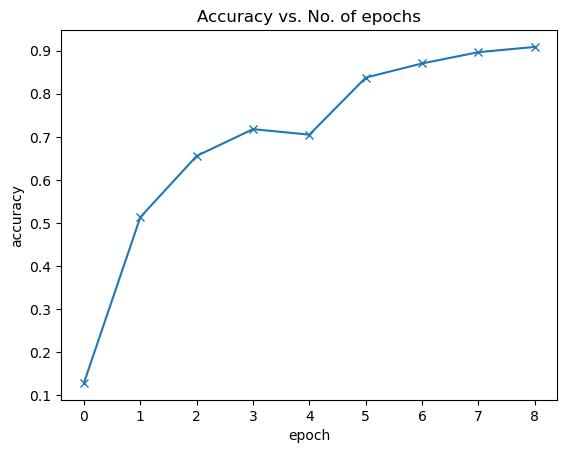

In [25]:
plot_accuracies(history)

### Plotting the losses

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs. No. of epochs')

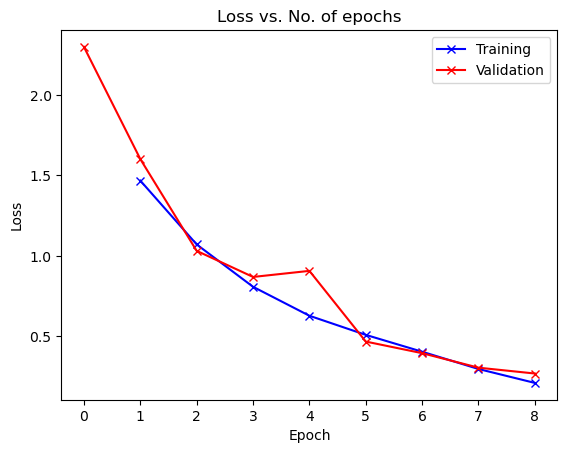

In [27]:
plot_losses(history)

### Plotting the learning rates

In [28]:
def plot_lrs(history):
    lrs =  np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel("Batch No")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate vs Batch No.")

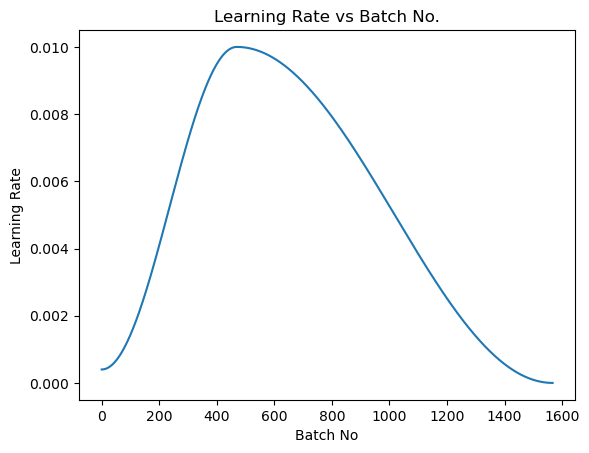

In [29]:
plot_lrs(history)

### Testing Individual Images

In [30]:
def predict_image(img, model):
    # Convert to batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # get predictions from model
    yb =  model(xb)
    # Pick index with highest probability
    _,preds =  torch.max(yb,dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


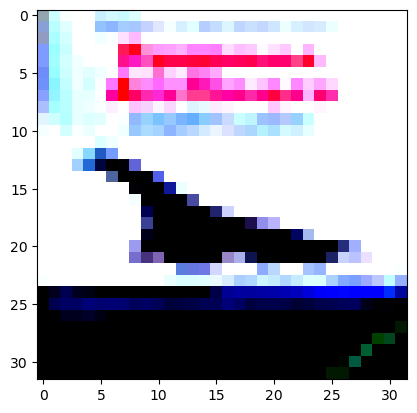

In [31]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


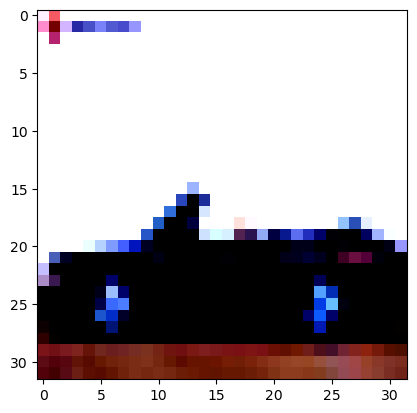

In [32]:
img, label = valid_ds[1024]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


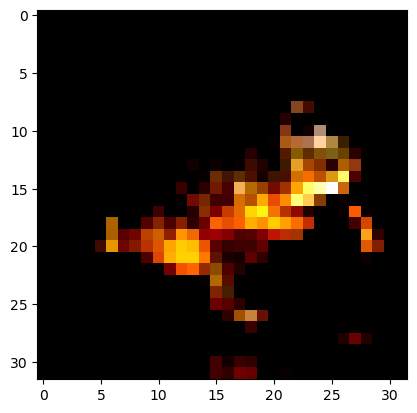

In [33]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

### Save the Model

In [34]:
torch.save(model.state_dict(), 'cifar10-resnet9.path')